In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import re
import tensorflow
import math
import csv
from os import listdir
from os.path import isfile, join
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import binarize
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
from os import listdir
from os.path import isfile, join
from gensim.models.word2vec import Word2Vec

In [3]:
Path = './Keywords/'
dfpest = pd.read_excel(Path+'02pest.list.xlsx', header=None)
dfchem = pd.read_excel(Path+'02chem.list.xlsx', header=None)
dfcrop = pd.read_excel(Path+'02crop.list.xlsx', header=None)


dftotal = pd.concat([dfpest, dfchem, dfcrop], ignore_index=True)
dftotal.insert(len(dftotal.columns), 'nan', None)
Names = dftotal[0]
syms_dict = {}
for i in range(len(dftotal[0])):
    j = 0
    while (not pd.isnull(dftotal.iloc[i,j])):
        syms_dict[dftotal.iloc[i,j]] = dftotal.iloc[i,0]
        j += 1


In [4]:
train_pre = pd.read_csv('Train_data.csv')
paras = [re.sub("\'| |\[|\]", '', text).split(',') for text in train_pre['text']]
public_pre = pd.read_csv('Public_data.csv')
paras1 = [re.sub("\'| |\[|\]", '', text).split(',') for text in public_pre['text']]

In [5]:
vz=250
model_w2v = Word2Vec(paras+paras1, vector_size=vz, epochs=20, sg=1,min_count=0,window=10,workers=5)

In [6]:
def one_hot(num,Tot):
    x=[]
    for i in range(num):
        x.append(0)
    x.append(1)
    for i in range(Tot-num-1):
        x.append(0)
    return np.array(x)

In [7]:
def count_times(lis,ele,bol):
    if bol:
        if ele in lis:
            return 1
        else:
            return 0
    else:
        if ele in lis:
            mm=0
            for i in lis:
                if i==ele:
                    mm+=1
            return mm
        else:
            return 0

In [8]:
mypath="./dataTrainComplete_1/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

comps=[]
ordering=[]
for i in onlyfiles:
    ordering.append(np.int(i[:-4]))
for i in ordering:
    for j in ordering:
        if i!=j:
            comps.append([i,j])

Word_freq_all=[]
Word_freq_sent_all=[] # add the exist keyword in each file
Word_freq_all_w2v=[] # directly add the word2vec of every word in each file
lens=[]
for par_ in paras:
    word_count=np.zeros(len(Names))
    word_count_sent=''
    w2v=np.zeros(vz)
    
    for i in range(len(Names)):
        if Names[i] in par_:
            for j in range(count_times(par_,Names[i],True)):
                word_count+=one_hot(i,len(Names))
                word_count_sent+=(Names[i]+' ')
                w2v+=model_w2v.wv[Names[i]]
    Word_freq_all.append(word_count)
    Word_freq_sent_all.append(word_count_sent)
    Word_freq_all_w2v.append(w2v/np.sum(word_count))
    lens.append(np.sum(word_count))


C:\Users\Billy\anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [9]:
df = pd.read_csv ('TrainLabel.csv',header=None)
labels=[]
for i in range(len(df.iloc[:][0])-1):
    i+=1
    labels.append([np.int(df.iloc[i][0]),np.int(df.iloc[i][1])])
    
    
Word_freq_all=np.array(Word_freq_all)
data=Word_freq_all
data_w2v=Word_freq_all_w2v


similarity=[]
diff=[]
similarity_w2v=[]
diff_w2v=[]
group=[]
len_diff=[]
senten=[]
mins=[]

for i in range(data.shape[0]):
    sim=[]
    dif=[]
    
    sim_w2v=[]
    dif_w2v=[]
    gp=[]
    len_dif=[]
    sent=[]
    minn=[]
    for j in range(data.shape[0]):
        if i!=j:
            if (norm(data[i]) !=0 and norm(data[j])!=0):
                
                cos_sim = dot(data[i], data[j])/(norm(data[i])*norm(data[j]))
                cos_sim_w2v = dot(data_w2v[i], data_w2v[j])/(norm(data_w2v[i])*norm(data_w2v[j]))

                sim.append(cos_sim)
                sim_w2v.append(cos_sim_w2v)
                
                gp.append(dot(data[i], data[j])/np.sum(data[i]))
                dif.append(np.sum(data[i]-data[j]))
                dif_w2v.append(np.sum(data_w2v[i]-data_w2v[j]))
                len_dif.append(lens[i]-lens[j])
                minn.append(lens[i])
            else:
                sim.append(-1)
                sim_w2v.append(-1)
                gp.append(-1)
                dif.append(-1000)
                dif_w2v.append(-1000)
                len_dif.append(-1000)
                minn.append(-1)
            sent.append(Word_freq_sent_all[i]+'\n'+'\n'+Word_freq_sent_all[j])
            
    similarity.append(sim)
    diff.append(dif)
    group.append(gp)
    similarity_w2v.append(sim_w2v)
    diff_w2v.append(dif_w2v)
    len_diff.append(len_dif)
    senten.append(sent)
    mins.append(minn)
    
    
m=0
truth=[]
for j in comps:
    if j in labels:
        truth.append(1)
        m+=1
    else:
        truth.append(0)

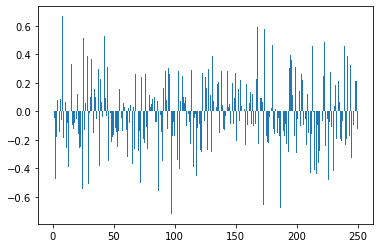

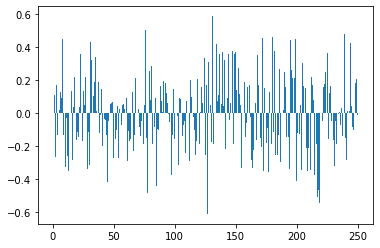

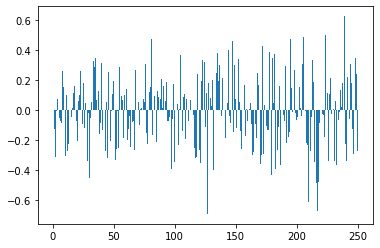

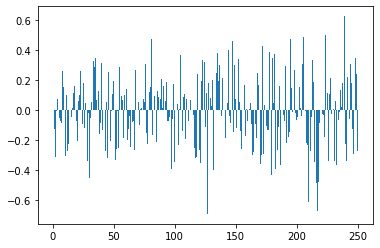

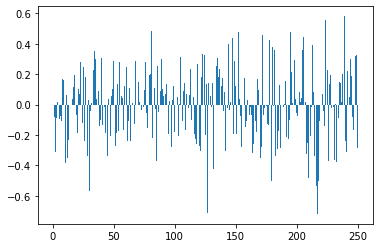

In [10]:
for i in range(5):
    plt.bar(np.linspace(1,len(Word_freq_all_w2v[i]),len(Word_freq_all_w2v[i])),Word_freq_all_w2v[i])
    plt.show()

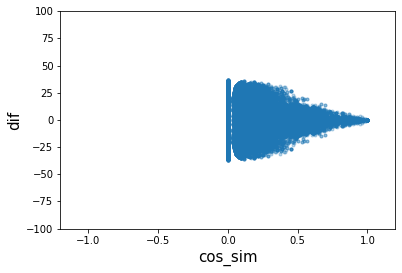

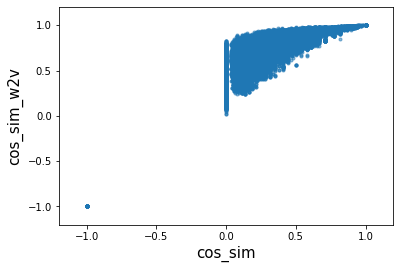

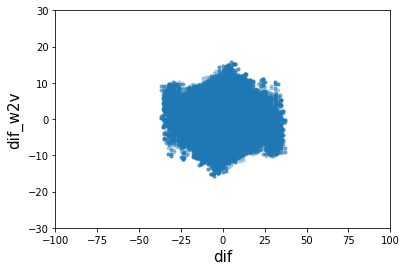

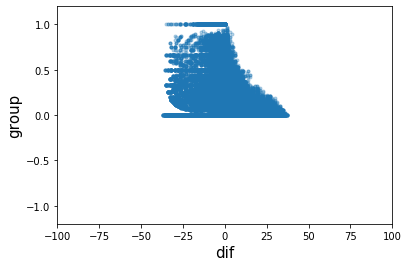

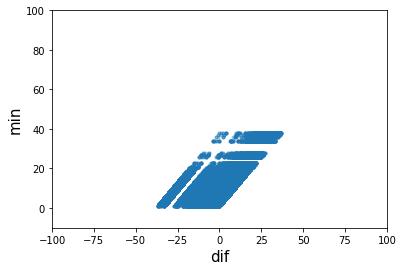

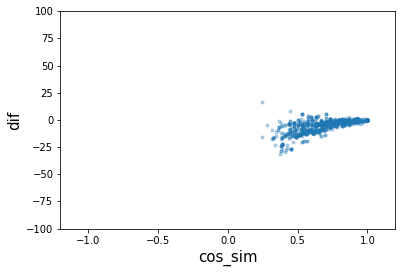

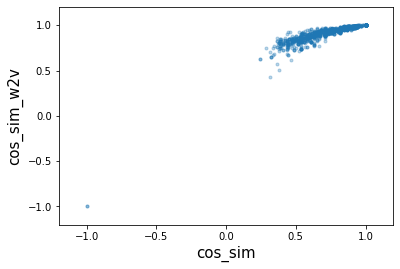

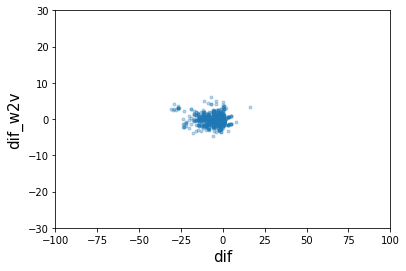

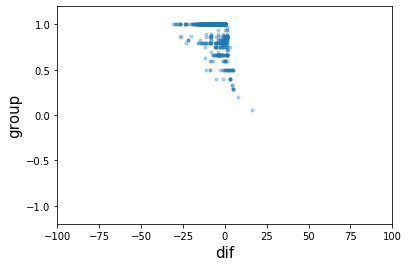

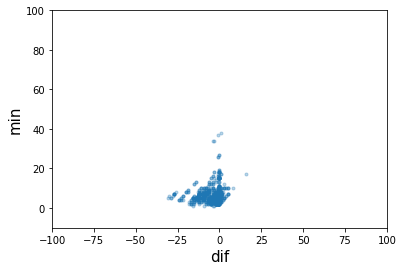

In [12]:
df_sim=pd.DataFrame(data={'Keys':comps,\
                          'cos_sim':np.array(similarity).reshape(-1),\
                          'dif':np.array(diff).reshape(-1),\
                          'labeled':np.array(truth),\
                          'cos_sim_w2v':np.array(similarity_w2v).reshape(-1),\
                          'dif_w2v':np.array(diff_w2v).reshape(-1),\
                          'group':np.array(group).reshape(-1),\
                          'sent':np.array(senten).reshape(-1),\
                          'min':np.array(mins).reshape(-1)})

df_lab=df_sim.loc[df_sim['labeled'] ==1]

plt.plot(np.array(df_sim['cos_sim']),np.array(df_sim['dif']),'.',alpha=0.3)
plt.xlim([-1.2,1.2])
plt.ylim([-100,100])
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('dif',fontsize=15)
plt.show()

plt.plot(np.array(df_sim['cos_sim']),np.array(df_sim['cos_sim_w2v']),'.',alpha=0.3)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('cos_sim_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_sim['dif']),np.array(df_sim['dif_w2v']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-30,30])
plt.xlabel('dif',fontsize=15)
plt.ylabel('dif_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_sim['dif']),np.array(df_sim['group']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-1.2,1.2])
plt.xlabel('dif',fontsize=15)
plt.ylabel('group',fontsize=15)
plt.show()


plt.plot(np.array(df_sim['dif']),np.array(df_sim['min']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-10,100])
plt.xlabel('dif',fontsize=15)
plt.ylabel('min',fontsize=15)
plt.show()

plt.plot(np.array(df_lab['cos_sim']),np.array(df_lab['dif']),'.',alpha=0.3)
plt.xlim([-1.2,1.2])
plt.ylim([-100,100])
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('dif',fontsize=15)
plt.show()

plt.plot(np.array(df_lab['cos_sim']),np.array(df_lab['cos_sim_w2v']),'.',alpha=0.3)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('cos_sim_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_lab['dif']),np.array(df_lab['dif_w2v']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-30,30])
plt.xlabel('dif',fontsize=15)
plt.ylabel('dif_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_lab['dif']),np.array(df_lab['group']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-1.2,1.2])
plt.xlabel('dif',fontsize=15)
plt.ylabel('group',fontsize=15)
plt.show()

plt.plot(np.array(df_lab['dif']),np.array(df_lab['min']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-10,100])
plt.xlabel('dif',fontsize=15)
plt.ylabel('min',fontsize=15)
plt.show()

In [14]:
df1=df_sim.loc[df_sim['cos_sim'] >0.3]
df2=df1.loc[(df1['dif'] <15) & (-35 < df1['dif'])]
df8=df2.loc[(df2['cos_sim_w2v'] >0.5)]
df9=df8.loc[(df8['dif_w2v'] >-8) & (df8['dif_w2v'] <8)]
df11=df9.loc[(df9['min'] >-1) & (df9['min'] <20)]
df3=df11.loc[(df11['group'] >0.2)]

X_scaled=np.array(df3[['cos_sim','dif','cos_sim_w2v','dif_w2v','group','min']])
data=np.concatenate([np.array(df3[['Keys']]),X_scaled],axis=1)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, np.array(df3[['labeled']]), test_size=0.33, random_state=42)

X_train1=[]
y_train1=[]

mm=0
for i in range(len(X_train)):
    if y_train[i]==1:
        mm+=1
        for j in range(14):
            X_train1.append(X_train[i,1:])
            y_train1.append(1)   
    else:
        X_train1.append(X_train[i,1:])
        y_train1.append(0)
print('mm',mm)
        
print('len/mm',len(X_train1)/mm)
        
    
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(128,64), activation='tanh',\
                    solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive',random_state=1, max_iter=500)

clf.fit(np.array(X_train1),np.array(y_train1).reshape(-1))

from sklearn.metrics import confusion_matrix
y_pred=clf.predict(X_test[:,1:])
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

from sklearn.model_selection import train_test_split
X_test, y_test = [data, np.array(df3[['labeled']])]

y_pred=clf.predict(X_test[:,1:])
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

mm 921
len/mm 27.99782844733985
[[6224  135]
 [  41  404]]
[[18961   290]
 [   44  1322]]


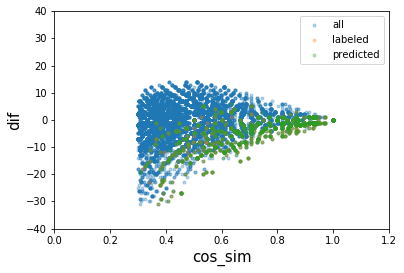

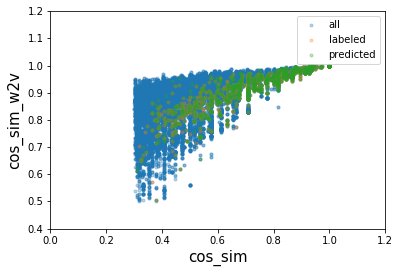

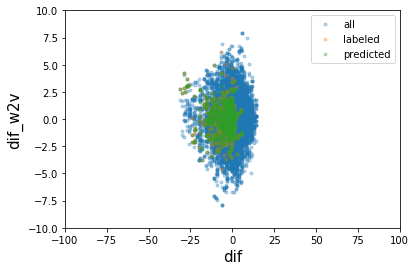

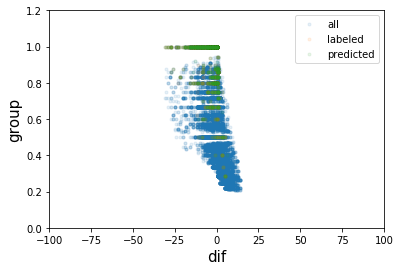

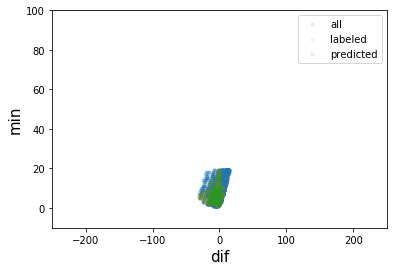

In [15]:
df3=df11.loc[(df11['group'] >0.2)]
df3.insert(1,'pred',y_pred)
df_sim1=df3

df_lab=df_sim1.loc[df_sim1['labeled'] ==1]
df_pred=df_sim1.loc[df_sim1['pred'] ==1]

plt.plot(np.array(df_sim1['cos_sim']),np.array(df_sim1['dif']),'.',alpha=0.3,label='all')
plt.plot(np.array(df_lab['cos_sim']),np.array(df_lab['dif']),'.',alpha=0.3,label='labeled')
plt.plot(np.array(df_pred['cos_sim']),np.array(df_pred['dif']),'.',alpha=0.3,label='predicted')
plt.xlim([0,1.2])
plt.ylim([-40,40])
plt.legend()
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('dif',fontsize=15)
plt.show()

plt.plot(np.array(df_sim1['cos_sim']),np.array(df_sim1['cos_sim_w2v']),'.',alpha=0.3,label='all')
plt.plot(np.array(df_lab['cos_sim']),np.array(df_lab['cos_sim_w2v']),'.',alpha=0.3,label='labeled')
plt.plot(np.array(df_pred['cos_sim']),np.array(df_pred['cos_sim_w2v']),'.',alpha=0.3,label='predicted')
plt.xlim([0,1.2])
plt.ylim([0.4,1.2])
plt.legend()
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('cos_sim_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_sim1['dif']),np.array(df_sim1['dif_w2v']),'.',alpha=0.3,label='all')
plt.plot(np.array(df_lab['dif']),np.array(df_lab['dif_w2v']),'.',alpha=0.3,label='labeled')
plt.plot(np.array(df_pred['dif']),np.array(df_pred['dif_w2v']),'.',alpha=0.3,label='predicted')
plt.xlim([-100,100])
plt.ylim([-10,10])
plt.legend()
plt.xlabel('dif',fontsize=15)
plt.ylabel('dif_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_sim1['dif']),np.array(df_sim1['group']),'.',alpha=0.1,label='all')
plt.plot(np.array(df_lab['dif']),np.array(df_lab['group']),'.',alpha=0.1,label='labeled')
plt.plot(np.array(df_pred['dif']),np.array(df_pred['group']),'.',alpha=0.1,label='predicted')
plt.xlim([-100,100])
plt.ylim([0,1.2])
plt.legend()
plt.xlabel('dif',fontsize=15)
plt.ylabel('group',fontsize=15)
plt.show()

plt.plot(np.array(df_sim1['dif']),np.array(df_sim1['min']),'.',alpha=0.1,label='all')
plt.plot(np.array(df_lab['dif']),np.array(df_lab['min']),'.',alpha=0.1,label='labeled')
plt.plot(np.array(df_pred['dif']),np.array(df_pred['min']),'.',alpha=0.1,label='predicted')
plt.xlim([-250,250])
plt.ylim([-10,100])
plt.legend()
plt.xlabel('dif',fontsize=15)
plt.ylabel('min',fontsize=15)
plt.show()



In [23]:
df_sim1.loc[(df_sim1['pred']==1) & (df_sim1['labeled']==0)]

,Keys,pred,cos_sim,dif,labeled,cos_sim_w2v,dif_w2v,group,sent,min
818,"[10, 344]",1,0.507833,-9.0,0,0.931918,0.406242,0.700000,稻熱病 葉稻熱病 亞磷酸 微生物製劑 三賽唑 亞賜圃 嘉賜黴素 喜樂克拉 護粒松 水稻 \n...,10.0
1120,"[1000, 1010]",1,0.866025,1.0,0,0.961964,0.304495,0.750000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 水稻,4.0
1307,"[1000, 188]",1,1.000000,0.0,0,1.000000,0.000000,1.000000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 葉稻熱病 水稻,4.0
1346,"[1000, 289]",1,0.866025,1.0,0,0.961964,0.304495,0.750000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 水稻,4.0
1465,"[1000, 576]",1,0.755929,-3.0,0,0.901809,0.213840,1.000000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 葉稻熱病 三賽唑 加普胺 滅大松...,4.0
1630,"[1000, 891]",1,0.566947,-3.0,0,0.804684,-0.283108,0.750000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n褐飛蝨 斑飛蝨 稻熱病 穗稻熱病 水稻縞葉枯病 毒...,4.0
1678,"[1005, 1010]",1,0.866025,1.0,0,0.961964,0.304495,0.750000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 水稻,4.0
1865,"[1005, 188]",1,1.000000,0.0,0,1.000000,0.000000,1.000000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 葉稻熱病 水稻,4.0
1904,"[1005, 289]",1,0.866025,1.0,0,0.961964,0.304495,0.750000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 水稻,4.0
2023,"[1005, 576]",1,0.755929,-3.0,0,0.901809,0.213840,1.000000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 葉稻熱病 三賽唑 加普胺 滅大松...,4.0


In [22]:
df_sim1.loc[(df_sim1['pred']==0) & (df_sim1['labeled']==1)]

,Keys,pred,cos_sim,dif,labeled,cos_sim_w2v,dif_w2v,group,sent,min
41361,"[1186, 1173]",0,0.771517,-1.0,1,0.932628,0.985472,0.833333,花薊馬 第滅寧 陶斯松 滅大松 香蕉 雜草 \n\n花薊馬 水銹斑 成熟斑 第滅寧 陶斯松 ...,6.0
41362,"[1186, 1176]",0,0.912871,1.0,1,0.971190,0.717000,0.833333,花薊馬 第滅寧 陶斯松 滅大松 香蕉 雜草 \n\n花薊馬 第滅寧 陶斯松 滅大松 香蕉,6.0
44715,"[1194, 1187]",0,0.600000,0.0,1,0.839877,-0.126429,0.600000,黑星病 葉斑病 鋅錳乃浦 滅大松 香蕉 \n\n鋅錳乃浦 滅大松 礦物油 普克利 香蕉,5.0
53648,"[1236, 1194]",0,0.894427,-1.0,1,0.962379,1.458956,1.000000,黑星病 葉斑病 鋅錳乃浦 香蕉 \n\n黑星病 葉斑病 鋅錳乃浦 滅大松 香蕉,4.0
60380,"[1261, 1282]",0,0.471405,-3.0,1,0.808373,-0.854598,0.666667,滅大松 凡殺護矽得 香蕉 \n\n黑星病 甲基多保淨 亞托敏 普克利 凡殺護矽得 香蕉,3.0
85555,"[1357, 170]",0,0.436436,-4.0,1,0.778063,4.045241,0.666667,薊馬 小黃薊馬 檬果 \n\n炭疽病 黑斑病 小黃薊馬 煤煙病 白粉病 葉蟬 檬果,3.0
93352,"[1392, 1391]",0,0.824958,1.0,1,0.974874,-0.065905,0.777778,疫病 炭疽病 果腐病 褐腐病 凡殺克絕 亞托待克利 賽座滅 克熱淨(烷苯磺酸鹽) 蓮霧 \n...,9.0
106496,"[185, 819]",0,0.500000,-3.0,1,0.825874,2.496352,1.000000,斜紋夜蛾 \n\n斜紋夜蛾 甜菜夜蛾 瓜實蠅 夜蛾類,1.0
107370,"[188, 296]",0,0.750000,0.0,1,0.921801,-0.209324,0.750000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病 紋枯病 水稻,4.0
107607,"[188, 809]",0,0.707107,2.0,1,0.915115,2.993895,0.500000,稻熱病 穗稻熱病 葉稻熱病 水稻 \n\n稻熱病 穗稻熱病,4.0


In [27]:
mypath="./dataPublicComplete/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

public_pre = pd.read_csv('Public_data.csv')
paras1 = [re.sub("\'| |\[|\]", '', text).split(',') for text in public_pre['text']]

comps=[]
ordering=[]
for i in onlyfiles:
    ordering.append(np.int(i[:-4]))
for i in ordering:
    for j in ordering:
        if i!=j:
            comps.append([i,j])

Word_freq_all=[]
Word_freq_sent_all=[]
Word_freq_all_w2v=[]
lens=[]
for par_ in paras1:
    word_count=np.zeros(len(Names))
    word_count_sent=''
    w2v=np.zeros(vz)
    
    for i in range(len(Names)):
        if Names[i] in par_:
            for j in range(count_times(par_,Names[i],True)):
                word_count+=one_hot(i,len(Names))
                word_count_sent+=(Names[i]+' ')
                w2v+=model_w2v.wv[Names[i]]
    Word_freq_all.append(word_count)
    Word_freq_sent_all.append(word_count_sent)
    Word_freq_all_w2v.append(w2v/np.sum(word_count))
    lens.append(np.sum(word_count))
    
    
df = pd.read_csv ('TrainLabel.csv',header=None)
labels=[]
for i in range(len(df.iloc[:][0])-1):
    i+=1
    labels.append([np.int(df.iloc[i][0]),np.int(df.iloc[i][1])])
    
Word_freq_all=np.array(Word_freq_all)
data=Word_freq_all
data_w2v=Word_freq_all_w2v

similarity=[]
diff=[]
similarity_w2v=[]
diff_w2v=[]
group=[]
len_diff=[]
senten=[]
mins=[]

for i in range(data.shape[0]):
    sim=[]
    dif=[]
    
    sim_w2v=[]
    dif_w2v=[]
    gp=[]
    len_dif=[]
    sent=[]
    minn=[]
    for j in range(data.shape[0]):
        if i!=j:
            if (norm(data[i]) !=0 and norm(data[j])!=0):
                
                cos_sim = dot(data[i], data[j])/(norm(data[i])*norm(data[j]))
                cos_sim_w2v = dot(data_w2v[i], data_w2v[j])/(norm(data_w2v[i])*norm(data_w2v[j]))

                sim.append(cos_sim)
                sim_w2v.append(cos_sim_w2v)
                
                gp.append(dot(data[i], data[j])/np.sum(data[i]))
                dif.append(np.sum(data[i]-data[j]))
                dif_w2v.append(np.sum(data_w2v[i]-data_w2v[j]))
                len_dif.append(lens[i]-lens[j])
                minn.append(lens[i])
            else:
                sim.append(-1)
                sim_w2v.append(-1)
                gp.append(-1)
                dif.append(-1000)
                dif_w2v.append(-1000)
                len_dif.append(-1000)
                minn.append(-1)
            sent.append(Word_freq_sent_all[i]+'\n'+'\n'+Word_freq_sent_all[j])
            
    similarity.append(sim)
    diff.append(dif)
    group.append(gp)
    similarity_w2v.append(sim_w2v)
    diff_w2v.append(dif_w2v)
    len_diff.append(len_dif)
    senten.append(sent)
    mins.append(minn)
    
    

C:\Users\Billy\anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


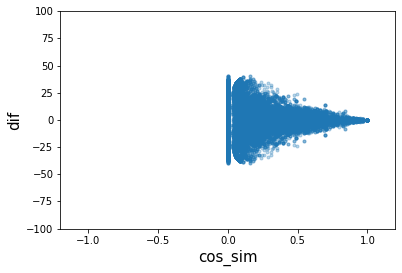

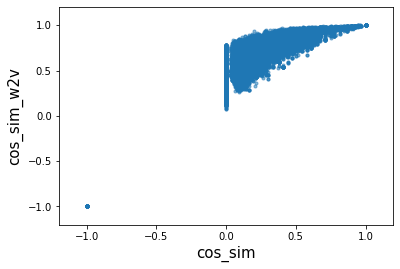

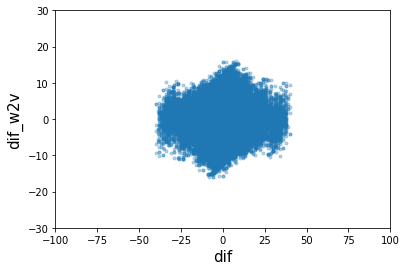

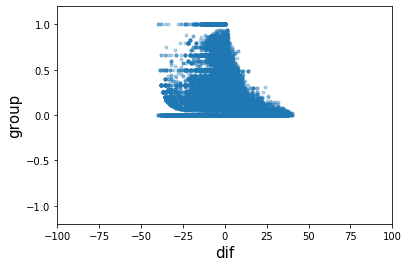

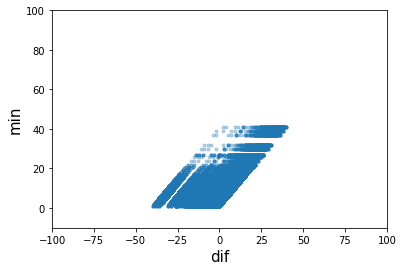

In [28]:
df_sim=pd.DataFrame(data={'Keys':comps,\
                          'cos_sim':np.array(similarity).reshape(-1),\
                          'dif':np.array(diff).reshape(-1),\
                          'cos_sim_w2v':np.array(similarity_w2v).reshape(-1),\
                          'dif_w2v':np.array(diff_w2v).reshape(-1),\
                          'group':np.array(group).reshape(-1),\
                          'sent':np.array(senten).reshape(-1),\
                          'min':np.array(mins).reshape(-1)})


plt.plot(np.array(df_sim['cos_sim']),np.array(df_sim['dif']),'.',alpha=0.3)
plt.xlim([-1.2,1.2])
plt.ylim([-100,100])
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('dif',fontsize=15)
plt.show()

plt.plot(np.array(df_sim['cos_sim']),np.array(df_sim['cos_sim_w2v']),'.',alpha=0.3)
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.xlabel('cos_sim',fontsize=15)
plt.ylabel('cos_sim_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_sim['dif']),np.array(df_sim['dif_w2v']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-30,30])
plt.xlabel('dif',fontsize=15)
plt.ylabel('dif_w2v',fontsize=15)
plt.show()

plt.plot(np.array(df_sim['dif']),np.array(df_sim['group']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-1.2,1.2])
plt.xlabel('dif',fontsize=15)
plt.ylabel('group',fontsize=15)
plt.show()


plt.plot(np.array(df_sim['dif']),np.array(df_sim['min']),'.',alpha=0.3)
plt.xlim([-100,100])
plt.ylim([-10,100])
plt.xlabel('dif',fontsize=15)
plt.ylabel('min',fontsize=15)
plt.show()


In [29]:
df1=df_sim.loc[df_sim['cos_sim'] >0.3]
df2=df1.loc[(df1['dif'] <15) & (-35 < df1['dif'])]
df8=df2.loc[(df2['cos_sim_w2v'] >0.5)]
df9=df8.loc[(df8['dif_w2v'] >-8) & (df8['dif_w2v'] <8)]
df11=df9.loc[(df9['min'] >1) & (df9['min'] <20)]
df3=df11.loc[(df11['group'] >0.8)]


# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(np.array(df3[['cos_sim','dif','lens','cos_sim_w2v','dif_w2v','group','min']]))
# X_scaled = scaler.transform(np.array(df3[['cos_sim','dif','lens','cos_sim_w2v','dif_w2v','group','min']]))

X_scaled=np.array(df3[['cos_sim','dif','cos_sim_w2v','dif_w2v','group','min']])

# from sklearn.decomposition import PCA
# pca = PCA(n_components=7)
# pca.fit(np.array(df3[['cos_sim','dif','lens','cos_sim_w2v','dif_w2v','group','min']]))
# X_scaled=pca.transform(np.array(df3[['cos_sim','dif','lens','cos_sim_w2v','dif_w2v','group','min']]))


y_pred=(clf.predict_proba(X_scaled)[:,1]> 0.5).astype("int64")

sel=[]
for i in range(len(y_pred)):
    if y_pred[i]==1:
        sel.append(df3.iloc[i,0])
        
print(len(sel))

data = {'Test': np.array(sel)[:,0], 'Reference': np.array(sel)[:,1]}
df = pd.DataFrame(data)
df.to_csv('select_name_test.csv', index=False) 

592
